# Brain Tumors Detector

### Goal : Test different models to classify tumor zones on brain scans

Models tested :

* RandomForest Classifier
* SVC (C-Support Vector Classification)
* MLPClassifier
* CatBoost



In [2]:
# Imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
import json

# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [3]:
# setup the resources location
PATH_TO_RESOURCES = "./data/"

train_data_x = np.memmap(PATH_TO_RESOURCES + "train_data_x.dat", mode='r',
                        dtype=np.float32, shape=(256, 240, 240, 4))
train_data_y = np.memmap(PATH_TO_RESOURCES + "train_data_y.dat", mode='r',
                        dtype=np.uint8, shape=(256, 240, 240))
test_data_x = np.memmap(PATH_TO_RESOURCES + "test_data_x.dat", mode='r',
                        dtype=np.float32, shape=(29, 240, 240, 4))

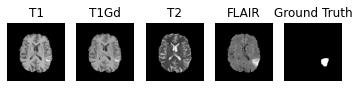

In [4]:
def display(array_x, array_y, brain):
    plt.subplot(151)
    plt.imshow(array_x[brain, :, :, 0], cmap='Greys_r')
    plt.axis('off')
    plt.title("T1")
    plt.subplot(152)
    plt.imshow(array_x[brain, :, :, 1], cmap='Greys_r')
    plt.axis('off')
    plt.title("T1Gd")
    plt.subplot(153)
    plt.imshow(array_x[brain, :, :, 2], cmap='Greys_r')
    plt.axis('off')
    plt.title("T2")
    plt.subplot(154)
    plt.imshow(array_x[brain, :, :, 3], cmap='Greys_r')
    plt.axis('off')
    plt.title("FLAIR")
    plt.subplot(155)
    plt.imshow(array_y[brain, :, :], cmap='Greys_r')
    plt.axis('off')
    plt.title("Ground Truth")
    plt.show()


display(train_data_x, train_data_y, 2)

In [5]:
nb_train_slices = 20

In [6]:
train_data_sample_ids = np.random.choice(len(train_data_x), nb_train_slices, replace=False)
print(train_data_sample_ids)
train_data_x_sample = [train_data_x[x] for x in train_data_sample_ids]

[188 185 187 124 197 174  42  79  29  92 106  22  27 141 166 169 126  44
 218 129]


In [7]:
train_data_y_sample = [train_data_y[x] for x in train_data_sample_ids]

In [8]:
train_data_x_sample = np.array(train_data_x_sample)
train_data_x_sample.shape, train_data_x_sample
train_data_y_sample = np.array(train_data_y_sample)
train_data_x_sample.shape, train_data_y_sample.shape

((20, 240, 240, 4), (20, 240, 240))

# Plot Samples

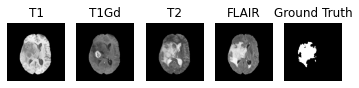

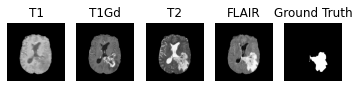

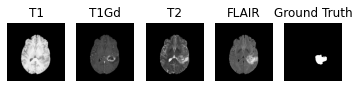

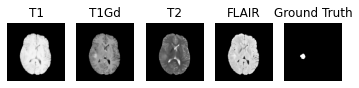

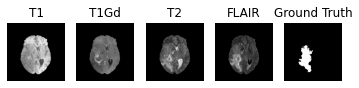

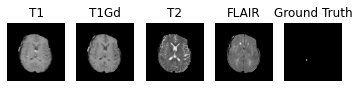

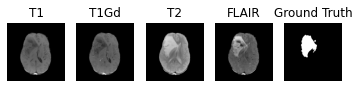

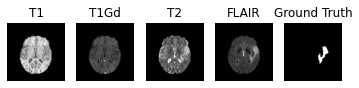

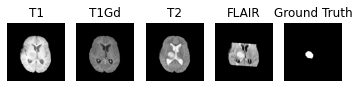

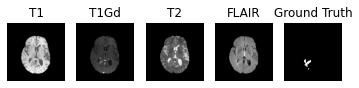

In [9]:
for i in range(10):
    display(train_data_x_sample, train_data_y_sample, i)

In [10]:
nb_val_slices = 30

In [11]:
rtx = []
for i in range(len(train_data_x)):
    if not (i in train_data_sample_ids): 
        rtx.append(i)
print(len(rtx))
val_data_sample_ids = np.random.choice(rtx, nb_val_slices, replace=False)
val_data_x_sample = [train_data_x[x] for x in val_data_sample_ids]
val_data_x_sample = np.array(val_data_x_sample)
val_data_x_sample.shape

236


(30, 240, 240, 4)

In [12]:
val_data_y_sample = [train_data_y[x] for x in val_data_sample_ids]
val_data_y_sample = np.array(val_data_y_sample)
val_data_y_sample.shape

(30, 240, 240)

In [13]:
def slices_to_masks(slices):
    '''
    Computes the foreground masks for each slice in a stack.

    Arguments
    ---------
    slices: numpy.array, shape (NUM_SLICES, 240, 240, 4)
        an array of slices for which every pixel belonging to the background has 
        the smallest possible value in each modality.

    Returns
    -------
    slices_masks: numpy.array, shape (NUM_SLICES, 240, 240), dtype numpy.bool
        the maks for each of the original slices indicating the foreground pixels.

    '''
    if slices.ndim != 4:
        raise ValueError("slices_to_masks expects as parameter an array of 4 dimensions (numslices, rows, cols, features)."
                         " It got instead an array of %s dimensions" % (slices.ndim, ))
    slices_min = np.min(slices, axis=(1, 2))
    slices_masks = np.all(slices > slices_min[:, np.newaxis, np.newaxis, :],
                          axis=-1)
    return slices_masks

In [14]:
mask_train_data_sample = slices_to_masks(train_data_x_sample)
mask_train_data_sample.shape

(20, 240, 240)

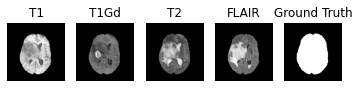

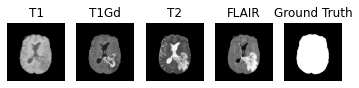

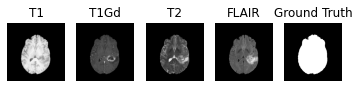

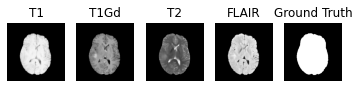

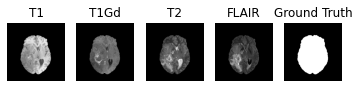

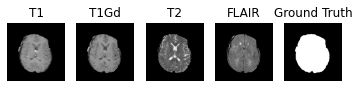

In [15]:
for ii in range(train_data_x_sample.shape[0])[:6]:
    # display_slices(train_data_x_sample[ii], mask_train_data_sample[ii])
    display(train_data_x_sample, mask_train_data_sample, ii)

In [16]:
train_data_x_sample.shape, mask_train_data_sample.shape

((20, 240, 240, 4), (20, 240, 240))

In [17]:
train_data_x_sample = (train_data_x_sample[mask_train_data_sample])
train_data_y_sample = (train_data_y_sample[mask_train_data_sample])

train_data_x_sample.shape, train_data_y_sample.shape
# we expect shapes like:
# - (169144, 4) for train_data_x_sample
# - (169144,) for train_data_y_sample

((330390, 4), (330390,))

In [18]:
from sklearn.svm import SVC
svclassifier = SVC(gamma='auto')

In [19]:
# Check the shape of your inputs before firing the training!
train_data_x_sample.shape, train_data_y_sample.shape

((330390, 4), (330390,))

In [20]:
svclassifier.fit(train_data_x_sample,train_data_y_sample)

SVC(gamma='auto')

In [21]:
val_data_x_sample.shape

(30, 240, 240, 4)

In [22]:
mask_val_data_sample = slices_to_masks(val_data_x_sample)
val_data_x_sample = (val_data_x_sample[mask_val_data_sample])
val_data_y_sample = (val_data_y_sample[mask_val_data_sample])

In [23]:
# evaluate
score = svclassifier.score(val_data_x_sample, val_data_y_sample)
print("score ", score)

score  0.9445947485608461


In [24]:
from sklearn.metrics import classification_report, confusion_matrix  

In [25]:
import warnings

def dice_score(y_true, y_pred):
    '''Compute the Dice coefficient between true and predicted values.'''
    for var, name in ((y_true, "y_true"), (y_pred, "y_pred")):
        if not isinstance(var, np.ndarray):
            raise ValueError("dice_score: `%s` must be a numpy array. Got object of type %s instead."
                             % (name, type(var)))
        if var.ndim != 1:
            raise ValueError("dice_score: `%s` must be 1-dimensional. Got %s.ndim=%d instead."
                             % (name, name, var.ndim))
        if not (var.dtype == np.uint8 or var.dtype == np.bool):
            warnings.warn("dice_score: `%s` should be either of type np.uint8 or np.bool. "
                          "Got %s instead. "
                          "Values will be projected on {0,1}."
                          % (name, var.dtype))

    if y_true.shape != y_pred.shape:
        raise ValueError("dice_score: `y_true` and `y_pred` must have the same shape. "
                         "Got y_true.shape=%s and y_pred.shape=%s instead."
                         % (y_true.shape, y_pred.shape))
    y_true_ = y_true != 0  # Project over {False,True}
    y_pred_ = y_pred != 0
    # The boolean union removes the duplicate intersection!
    union = np.sum(y_true_ + y_pred_)
    if union == 0:
        warnings.warn("dice_score: neither `y_true` nor `y_pred` contain positive values."
                      " The score is ill-defined. Returning `1.` without much faith...")
        return 1.
    inter = np.sum(y_true_ * y_pred_)
    # We need to re-add the intersection or we get the Jaccard index
    return 2 * inter / (union + inter)

In [26]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), svclassifier.predict(val_data_x_sample))
dscore

0.713459637068182

# C-Support Vector Classificatio (SVC)

In [27]:
svclassifier = SVC(gamma='auto', kernel='rbf')

In [28]:
svclassifier.fit(train_data_x_sample,train_data_y_sample)

SVC(gamma='auto')

In [29]:
val_data_ypred_sample = svclassifier.predict(val_data_x_sample)

In [30]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), svclassifier.predict(val_data_x_sample))
print("SVC Dice Score : ", dscore)
dscore

0.713459637068182

In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
mlpclf1 = MLPClassifier(alpha=1e-6, max_iter=200, solver='adam',
                        activation='relu', batch_size=256)
mlpclf1.fit(train_data_x_sample, train_data_y_sample)

MLPClassifier(alpha=1e-06, batch_size=256)

In [33]:
val_data_ypred_sample = mlpclf1.predict(val_data_x_sample)

In [34]:
dscore = dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)
print("MLPClassifier Dice Score : ", dscore)

dscore

0.7445771477471445

# RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
rfclass = RandomForestClassifier(n_estimators=500, max_depth=12)
rfclass.fit(train_data_x_sample, train_data_y_sample)
val_data_ypred_sample = rfclass.predict(val_data_x_sample)
dscore = dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)

print("RandomForestClassifier Dice Score : ", dscore)
dscore

0.7278095625320671

# CatBoost (2018)

In [56]:
import numpy as np

from catboost import CatBoostClassifier, Pool

catboost_model = CatBoostClassifier(loss_function='Logloss',
                           verbose=True,
                            iterations=1000,
                            learning_rate=0.3)


# train the model
catboost_model.fit(train_data_x_sample, train_data_y_sample)

# Score
val_data_ypred_sample = catboost_model.predict(val_data_x_sample)
dscore = dice_score(val_data_y_sample.reshape((-1,)), val_data_ypred_sample)

print("CatBoost Dice Score : ", dscore)
dscore

0:	learn: 0.2640421	total: 22.2ms	remaining: 22.2s
1:	learn: 0.1541747	total: 43.6ms	remaining: 21.7s
2:	learn: 0.1193361	total: 69.5ms	remaining: 23.1s
3:	learn: 0.1079340	total: 92.5ms	remaining: 23s
4:	learn: 0.1018580	total: 117ms	remaining: 23.3s
5:	learn: 0.0989589	total: 143ms	remaining: 23.7s
6:	learn: 0.0967293	total: 169ms	remaining: 24s
7:	learn: 0.0946195	total: 208ms	remaining: 25.8s
8:	learn: 0.0935682	total: 237ms	remaining: 26.1s
9:	learn: 0.0926337	total: 271ms	remaining: 26.8s
10:	learn: 0.0918982	total: 300ms	remaining: 27s
11:	learn: 0.0914570	total: 325ms	remaining: 26.8s
12:	learn: 0.0908016	total: 351ms	remaining: 26.7s
13:	learn: 0.0904344	total: 377ms	remaining: 26.5s
14:	learn: 0.0900869	total: 402ms	remaining: 26.4s
15:	learn: 0.0895126	total: 429ms	remaining: 26.4s
16:	learn: 0.0891747	total: 461ms	remaining: 26.7s
17:	learn: 0.0889136	total: 496ms	remaining: 27.1s
18:	learn: 0.0884375	total: 523ms	remaining: 27s
19:	learn: 0.0880900	total: 549ms	remaining: 

166:	learn: 0.0771965	total: 4.62s	remaining: 23s
167:	learn: 0.0771413	total: 4.64s	remaining: 23s
168:	learn: 0.0771082	total: 4.67s	remaining: 23s
169:	learn: 0.0770624	total: 4.7s	remaining: 23s
170:	learn: 0.0770393	total: 4.73s	remaining: 22.9s
171:	learn: 0.0770056	total: 4.76s	remaining: 22.9s
172:	learn: 0.0769671	total: 4.79s	remaining: 22.9s
173:	learn: 0.0769425	total: 4.82s	remaining: 22.9s
174:	learn: 0.0769190	total: 4.85s	remaining: 22.9s
175:	learn: 0.0768914	total: 4.88s	remaining: 22.8s
176:	learn: 0.0768582	total: 4.9s	remaining: 22.8s
177:	learn: 0.0768304	total: 4.93s	remaining: 22.8s
178:	learn: 0.0767886	total: 4.96s	remaining: 22.7s
179:	learn: 0.0767510	total: 4.99s	remaining: 22.7s
180:	learn: 0.0767181	total: 5.01s	remaining: 22.7s
181:	learn: 0.0766967	total: 5.04s	remaining: 22.7s
182:	learn: 0.0766585	total: 5.07s	remaining: 22.6s
183:	learn: 0.0766231	total: 5.1s	remaining: 22.6s
184:	learn: 0.0765856	total: 5.14s	remaining: 22.6s
185:	learn: 0.0765523	t

329:	learn: 0.0722568	total: 9.46s	remaining: 19.2s
330:	learn: 0.0722331	total: 9.49s	remaining: 19.2s
331:	learn: 0.0722201	total: 9.52s	remaining: 19.2s
332:	learn: 0.0722027	total: 9.55s	remaining: 19.1s
333:	learn: 0.0721648	total: 9.58s	remaining: 19.1s
334:	learn: 0.0721334	total: 9.61s	remaining: 19.1s
335:	learn: 0.0721086	total: 9.63s	remaining: 19s
336:	learn: 0.0720859	total: 9.66s	remaining: 19s
337:	learn: 0.0720559	total: 9.7s	remaining: 19s
338:	learn: 0.0720259	total: 9.73s	remaining: 19s
339:	learn: 0.0720042	total: 9.76s	remaining: 18.9s
340:	learn: 0.0719732	total: 9.79s	remaining: 18.9s
341:	learn: 0.0719566	total: 9.82s	remaining: 18.9s
342:	learn: 0.0719259	total: 9.85s	remaining: 18.9s
343:	learn: 0.0719084	total: 9.88s	remaining: 18.8s
344:	learn: 0.0718873	total: 9.91s	remaining: 18.8s
345:	learn: 0.0718623	total: 9.94s	remaining: 18.8s
346:	learn: 0.0718345	total: 9.98s	remaining: 18.8s
347:	learn: 0.0717977	total: 10s	remaining: 18.8s
348:	learn: 0.0717670	t

490:	learn: 0.0684866	total: 14.4s	remaining: 14.9s
491:	learn: 0.0684468	total: 14.4s	remaining: 14.9s
492:	learn: 0.0684265	total: 14.4s	remaining: 14.8s
493:	learn: 0.0684056	total: 14.5s	remaining: 14.8s
494:	learn: 0.0683886	total: 14.5s	remaining: 14.8s
495:	learn: 0.0683693	total: 14.5s	remaining: 14.8s
496:	learn: 0.0683448	total: 14.5s	remaining: 14.7s
497:	learn: 0.0683280	total: 14.6s	remaining: 14.7s
498:	learn: 0.0682923	total: 14.6s	remaining: 14.7s
499:	learn: 0.0682848	total: 14.6s	remaining: 14.6s
500:	learn: 0.0682543	total: 14.7s	remaining: 14.6s
501:	learn: 0.0682354	total: 14.7s	remaining: 14.6s
502:	learn: 0.0682127	total: 14.7s	remaining: 14.6s
503:	learn: 0.0682000	total: 14.8s	remaining: 14.5s
504:	learn: 0.0681864	total: 14.8s	remaining: 14.5s
505:	learn: 0.0681649	total: 14.8s	remaining: 14.5s
506:	learn: 0.0681480	total: 14.9s	remaining: 14.4s
507:	learn: 0.0681356	total: 14.9s	remaining: 14.4s
508:	learn: 0.0681152	total: 14.9s	remaining: 14.4s
509:	learn: 

653:	learn: 0.0654762	total: 19.2s	remaining: 10.2s
654:	learn: 0.0654591	total: 19.2s	remaining: 10.1s
655:	learn: 0.0654378	total: 19.3s	remaining: 10.1s
656:	learn: 0.0654268	total: 19.3s	remaining: 10.1s
657:	learn: 0.0654048	total: 19.3s	remaining: 10s
658:	learn: 0.0653852	total: 19.4s	remaining: 10s
659:	learn: 0.0653640	total: 19.4s	remaining: 9.98s
660:	learn: 0.0653511	total: 19.4s	remaining: 9.96s
661:	learn: 0.0653364	total: 19.4s	remaining: 9.93s
662:	learn: 0.0653235	total: 19.5s	remaining: 9.9s
663:	learn: 0.0653144	total: 19.5s	remaining: 9.87s
664:	learn: 0.0652974	total: 19.5s	remaining: 9.84s
665:	learn: 0.0652722	total: 19.6s	remaining: 9.81s
666:	learn: 0.0652558	total: 19.6s	remaining: 9.78s
667:	learn: 0.0652414	total: 19.6s	remaining: 9.75s
668:	learn: 0.0652197	total: 19.7s	remaining: 9.72s
669:	learn: 0.0652047	total: 19.7s	remaining: 9.69s
670:	learn: 0.0651946	total: 19.7s	remaining: 9.66s
671:	learn: 0.0651867	total: 19.7s	remaining: 9.63s
672:	learn: 0.065

814:	learn: 0.0627254	total: 24s	remaining: 5.46s
815:	learn: 0.0627129	total: 24.1s	remaining: 5.43s
816:	learn: 0.0626936	total: 24.1s	remaining: 5.4s
817:	learn: 0.0626789	total: 24.1s	remaining: 5.37s
818:	learn: 0.0626609	total: 24.2s	remaining: 5.34s
819:	learn: 0.0626463	total: 24.2s	remaining: 5.31s
820:	learn: 0.0626316	total: 24.2s	remaining: 5.28s
821:	learn: 0.0626132	total: 24.2s	remaining: 5.25s
822:	learn: 0.0625942	total: 24.3s	remaining: 5.22s
823:	learn: 0.0625779	total: 24.3s	remaining: 5.19s
824:	learn: 0.0625595	total: 24.3s	remaining: 5.16s
825:	learn: 0.0625433	total: 24.4s	remaining: 5.13s
826:	learn: 0.0625338	total: 24.4s	remaining: 5.1s
827:	learn: 0.0625177	total: 24.4s	remaining: 5.07s
828:	learn: 0.0624943	total: 24.5s	remaining: 5.04s
829:	learn: 0.0624827	total: 24.5s	remaining: 5.01s
830:	learn: 0.0624682	total: 24.5s	remaining: 4.99s
831:	learn: 0.0624501	total: 24.5s	remaining: 4.96s
832:	learn: 0.0624326	total: 24.6s	remaining: 4.93s
833:	learn: 0.06

975:	learn: 0.0603562	total: 28.9s	remaining: 711ms
976:	learn: 0.0603423	total: 28.9s	remaining: 681ms
977:	learn: 0.0603229	total: 29s	remaining: 652ms
978:	learn: 0.0603133	total: 29s	remaining: 622ms
979:	learn: 0.0603004	total: 29s	remaining: 592ms
980:	learn: 0.0602843	total: 29.1s	remaining: 563ms
981:	learn: 0.0602762	total: 29.1s	remaining: 533ms
982:	learn: 0.0602606	total: 29.1s	remaining: 504ms
983:	learn: 0.0602525	total: 29.2s	remaining: 474ms
984:	learn: 0.0602418	total: 29.2s	remaining: 444ms
985:	learn: 0.0602274	total: 29.2s	remaining: 415ms
986:	learn: 0.0602149	total: 29.2s	remaining: 385ms
987:	learn: 0.0601987	total: 29.3s	remaining: 356ms
988:	learn: 0.0601888	total: 29.3s	remaining: 326ms
989:	learn: 0.0601647	total: 29.3s	remaining: 296ms
990:	learn: 0.0601417	total: 29.4s	remaining: 267ms
991:	learn: 0.0601262	total: 29.4s	remaining: 237ms
992:	learn: 0.0601120	total: 29.4s	remaining: 207ms
993:	learn: 0.0600996	total: 29.5s	remaining: 178ms
994:	learn: 0.0600

<ipython-input-25-7608dd9527a2>:13: UserWarning: dice_score: `y_pred` should be either of type np.uint8 or np.bool. Got int64 instead. Values will be projected on {0,1}.
  warnings.warn("dice_score: `%s` should be either of type np.uint8 or np.bool. "


0.7041633813236768

In [57]:
print("CatBoost Dice Score : ", dscore)

CatBoost Dice Score :  0.7041633813236768


# Eval on Test Data

In [37]:
print('test_data_x shape ', test_data_x.shape)
# test_mask = slices_to_masks(test_data_x)
# test_data_x_masked = test_data_x[test_mask]
# print('test_data_x_masked shape ', test_data_x_masked.shape)
tsize = test_data_x.shape[0] * test_data_x.shape[1] * test_data_x.shape[2]

test_data_x_pix = test_data_x.reshape((tsize, 4))
print('test_data_x_pix shape ', test_data_x_pix.shape)


# Best Classifier
bestclassifier = mlpclf1

test_data_ypred = bestclassifier.predict(test_data_x_pix)  # prediction

test_data_x shape  (29, 240, 240, 4)
test_data_x_pix shape  (1670400, 4)


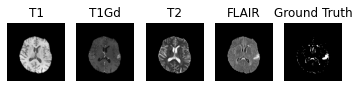

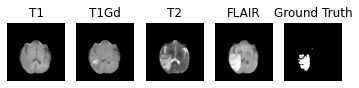

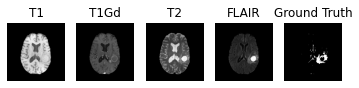

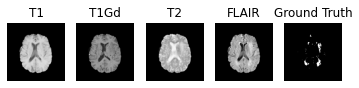

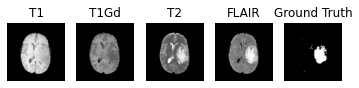

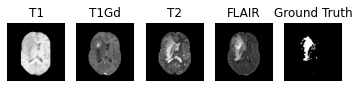

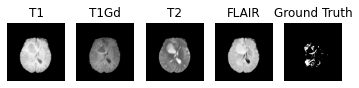

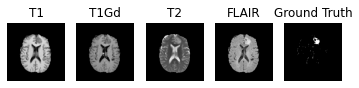

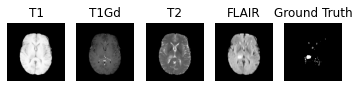

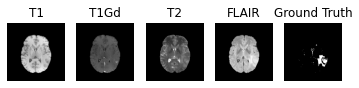

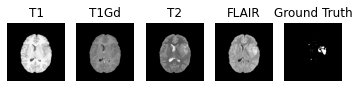

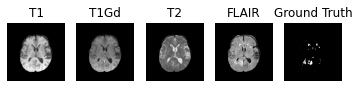

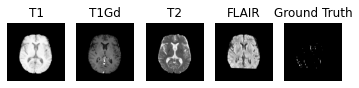

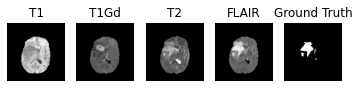

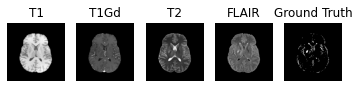

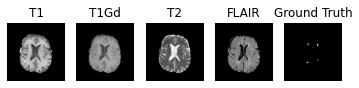

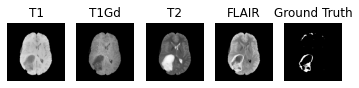

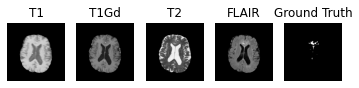

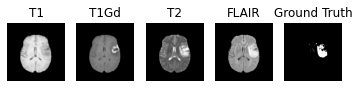

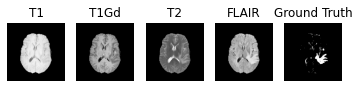

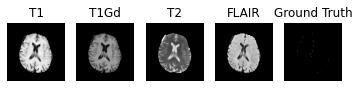

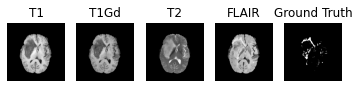

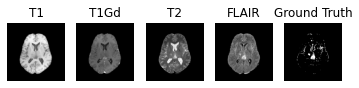

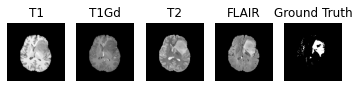

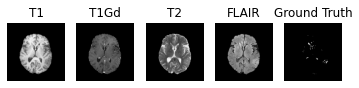

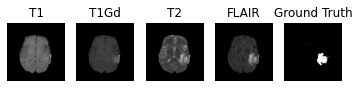

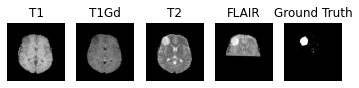

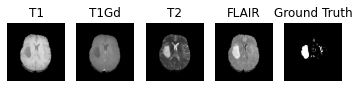

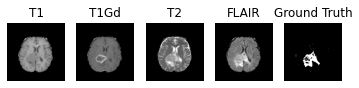

In [38]:
test_res = test_data_ypred.reshape((29, 240, 240))
for i in range(len(test_data_x)):
    display(test_data_x, test_res, i)

In [39]:
# Export Results

In [40]:
def export_test_predictions(test_ypred, filename='test_data_ypred.dat'):
    expected_shape = (29, 240, 240)
    expected_dtype = np.uint8
    # Check shape
    if test_ypred.shape != expected_shape:
        raise ValueError("export_test_predictions: your prediction do not have the right shape."
                         " Expected shape %s but got %s instead." % (expected_shape, test_ypred.shape))
    # Check dtype
    if test_ypred.dtype != expected_dtype:
        raise ValueError("export_test_predictions: your prediction do not have the right dtype."
                         " Expected dtype %s but got %s instead." % (expected_dtype, test_ypred.dtype))
    # Check values
    if np.sum(test_ypred == 1) + np.sum(test_ypred == 0) != np.prod(expected_shape):
        raise ValueError("export_test_predictions: your prediction should contain only binary (0 and 1)"
                         " values. It seems that you have other values.")
    # Seems ok
    test_data_ypred = np.memmap(filename, mode="w+", dtype=expected_dtype, shape=expected_shape)
    test_data_ypred[...] = test_ypred  # copy values
    # The buffer is automatically flushed on disk upon object destruction but can also be explicit
    test_data_ypred.flush()
    print("Wrote '%s'." % filename)

In [41]:
export_test_predictions(test_data_ypred.reshape((29, 240, 240)))

Wrote 'test_data_ypred.dat'.
